In [2]:
%load_ext autoreload
%autoreload 2

# Models

In [3]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from keras.models import Model, Sequential
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization, LSTM, GRU, CuDNNGRU, CuDNNLSTM, concatenate, Input, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.constraints import maxnorm

Using TensorFlow backend.


# Pre-processing

In [4]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import chardet
import re
import os
import random

In [5]:
#Checking files in Kaggle
# List data files that are connected to the kernel

#os.listdir('../input')

In [6]:
# Read Train & Test Files

#Kaggle
#train_file = bz2.BZ2File('../input/train.ft.txt.bz2')
#test_file = bz2.BZ2File('../input/test.ft.txt.bz2')

#Localhost
#train_file = bz2.BZ2File('C:/Users/Lenovo/Documents/GitHub/Datasets/amazonreviews/train.ft.txt.bz2')
#test_file = bz2.BZ2File('C:/Users/Lenovo/Documents/GitHub/Datasets/amazonreviews/test.ft.txt.bz2')

#Localhost - Versión recortada del archivo
train_file = bz2.BZ2File('C:/Users/Lenovo/Documents/GitHub/Datasets/amazonreviews/Version_Recortada/r_train.ft.txt.bz2')
test_file = bz2.BZ2File('C:/Users/Lenovo/Documents/GitHub/Datasets/amazonreviews/Version_Recortada/r_test.ft.txt.bz2')

#Create Lists containing Train & Test sentences
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

#Convert from raw binary strings to strings that can be parsed
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [7]:
#Delete memory reference (?)
del train_file, test_file
#Garbage collector
gc.collect()

0

In [8]:
print("Cantidad de elementos del Training Set: {}".format(len(train_file_lines)))
print("Cantidad de elementos del Testing Set: {}".format(len(test_file_lines)))

Cantidad de elementos del Training Set: 30000
Cantidad de elementos del Testing Set: 10000


## Clean data

In [9]:
# Change labels: __label__1 -> 0 (Negative) / __label__2 -> 1 (Positive)
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]

# Make everything Lower Case
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])

# Modify URLs to <url>
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

## Checking data before and after cleaning

In [10]:
#Random
r = random.randint(1,len(train_file_lines))

#Before
print("Data before cleaning:\n{}".format(train_file_lines[r-1:r]))

#After
print("\nData after cleaning:\n{}".format((train_sentences[r-1:r])))

#Labels
print("\nLabel:{}".format(train_labels[r-1:r]))

Data before cleaning:
["__label__2 on my shortest list of favorites: Just to add my voice to the rest here. It's hard to overstate the combination of message, artistry, and foresight in this book.\r\n"]

Data after cleaning:
["on my shortest list of favorites: just to add my voice to the rest here. it's hard to overstate the combination of message, artistry, and foresight in this book.\r"]

Label:[1]


### Output
From the above output it can be seen that each sentence begins with it's sentiment (label1 -> Negative, label2 -> Positive), which is then followed by the review and ends with a newline character \n.

So, first I go convert all the labels to O(Negative) and 1(Positive) and store it in lists that only contain the label values. After this, I store the remainder of the sentence excluding the newline character in lowercase in lists. Also, convert all numbers to 0.


In [11]:
#Delete memory reference (?)
del train_file_lines, test_file_lines
#Garbage collector
gc.collect()

0

### Content

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

In [48]:
Index = [0,1]
#Labels Count
Sentiment_Count = [sum(1 for pos in train_labels if pos == 1),sum(1 for pos in train_labels if pos == 0)]

Text(0.5,1,'Count of Sentiment')

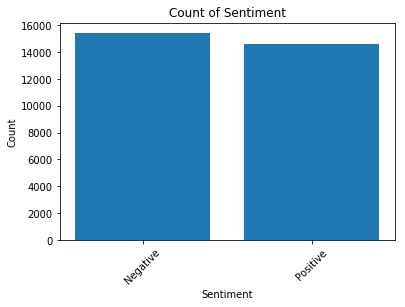

In [49]:
plt.bar(Index,Sentiment_Count)
plt.xticks(Index,['Negative','Positive'],rotation=45)
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Count of Sentiment')

In [60]:
#Armo los textos para la "wordcloud" - Positive
for i in range(len(train_sentences[i])):
    if (train_labels[i] == 1):
        cleaned_word_positive = " ".join((train_sentences[i]).split())
    else:
        cleaned_word_negative = " ".join((train_sentences[i]).split())

### Negative Wordcloud

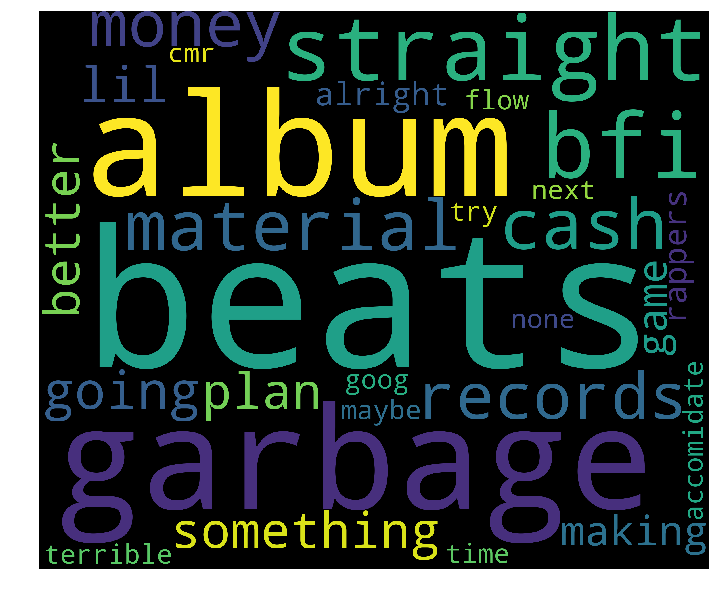

In [62]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word_negative)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Positive Wordcloud

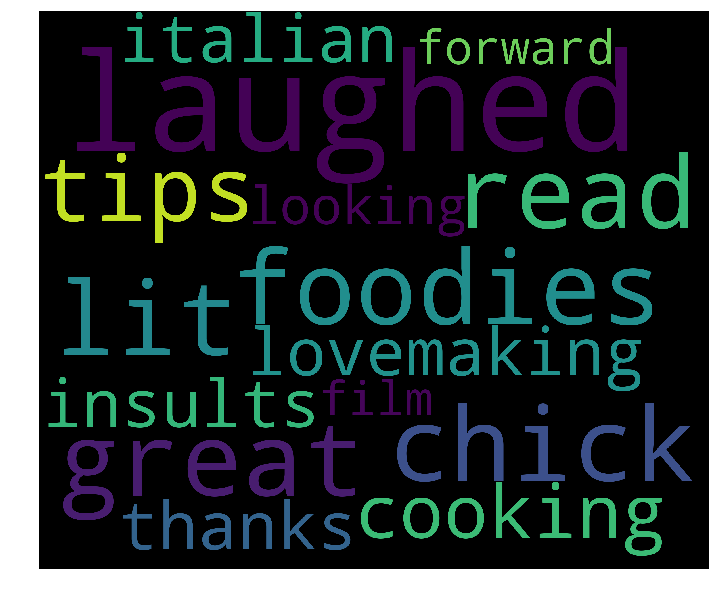

In [65]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word_positive)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()